# Drive Linking


In [ ]:
from google.colab import drive                                                  # Importa il modulo Drive di Google Colab

drive.mount('/content/drive')                                                   # Indirizzo base del drive

Mounted at /content/drive


# Library

In [ ]:
import sys

# Installa googletrans se non è già installato
if 'googletrans' not in sys.modules:
    !pip install googletrans==4.0.0-rc1

# Installa langdetect se non è già installato
if 'langdetect' not in sys.modules:
    !pip install langdetect

# Installa d2l se non è già installato
if 'd2l' not in sys.modules:
    !pip install d2l

# Installa nltk se non è già installato
if 'nltk' not in sys.modules:
    !pip install nltk

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.1/55.1 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.0/65.0 kB 6.9 MB/s eta 0:00:00
  Created wheel for googletrans: filename=googletrans-4.0.0rc1-py3-none-any.whl size=17395 sha256=be2245b17788ffc9bd74d65a3cc55e34048f53ebbbecab0522cc25cdc6f16378
  Stored in directory: /root/.cache/pip/wheels/c0/59/9f/7372f0cf70160fe61b528532e1a7c8498c4becd6bcffb022de
Successfully built googletrans
  Attempting uninstall: chardet
    Found existing installation: chardet 5.2.0
    Uninstalling 

In [ ]:
# Librerie per la manipolazione dei dati
import pandas as pd
import numpy as np
import scipy.io as sio  # Per lavorare con file MATLAB

# Librerie per l'elaborazione del linguaggio naturale (NLP)
import nltk
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from googletrans import Translator  # Per la traduzione
from langdetect import detect, LangDetectException  # Per il rilevamento della lingua

# Librerie per l'apprendimento automatico
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import tensorflow as tf
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, AdamW, get_linear_schedule_with_warmup, TFDistilBertForSequenceClassification
from transformers.optimization_tf import AdamWeightDecay

# Librerie per l'elaborazione parallela
import os
import multiprocessing

# Librerie per la gestione delle reti neurali
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.nn import CrossEntropyLoss

# Altre librerie di supporto
from tqdm import tqdm  # Per la barra di avanzamento
import d2l  # Deep Learning 2.0, una libreria per l'approfondimento sull'apprendimento automatico
import time  # Per la gestione del tempo

import json
import base64
import io
import seaborn as sns
import re

import matplotlib.pyplot as plt

In [ ]:
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

# Check Device

In [ ]:
# Imposta il dispositivo per l'esecuzione del modello su GPU se disponibile, altrimenti usa la CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
print("Version: " + str(torch.__version__))
print("Avaible?: " + str(torch.cuda.is_available()))
print("Device: " + str(torch.cuda.get_device_name(0)))
print("Run GPU?: " + str(device))

Version: 2.3.0+cu121
Avaible?: True
Device: Tesla T4
Run GPU?: cuda:0


# Path

In [ ]:
DATA_PATH = '/content/drive/MyDrive/CCS/Dataset'
DATASET_PATH = DATA_PATH + '/enron_spam_data.csv'
DATASET_CLEAR_PATH = DATA_PATH + '/enron_spam_data_clear.csv'
TRAIN_PATH = DATA_PATH + '/train.csv'
VAL_PATH = DATA_PATH + '/val.csv'
TEST_PATH = DATA_PATH + '/test.csv'
WEIGHTS_PATH = DATA_PATH + '/Weights'
TRAIN_FINAL_PATH = DATA_PATH + '/train_final.csv'
BEST_WEIGHT_PATH = WEIGHTS_PATH + '/Best_Weight'
MODEL_PATH = DATA_PATH + '/Model'

# Data Visualization & Pre-Processing



1.   lettura del set di dati da file CSV mediante l'uso della libreria Pandas
2.   creazione della colonna target mediante la sostituzione della lable spam con il valore 1 e della lable ham con il valore 0
3.   unione delle colonne Subject e Message al fine di ottenere il testo da utilizzare per la classificazione
4.   rimozione delle informazioni non necessarie (Date, Subject, Message e Message ID)
5.   creazione del dataframe finale composto dalle coppie (testo, label) = (Test, Spam/Ham)

In [ ]:
# Leggi il file CSV e assicurati che contenga colonne 'text' e 'label'
df = pd.read_csv(DATASET_PATH)

# Riconfigura la colonna 'Spam/Ham' in 1 per 'spam' e 0 per 'ham'
df['Spam/Ham'] = df['Spam/Ham'].map({'spam': 1, 'ham': 0})

# Unisci le colonne 'Subject' e 'Message' in una nuova colonna chiamata 'Text'
df['Text'] = df['Subject'] + ' ' + df['Message']

# Rimuovi le colonne specificate
df = df.drop(columns=['Date', 'Subject', 'Message', 'Message ID'])

# Ordina le colonne: 'Message ID', 'Text', 'Spam/Ham'
df = df[['Text', 'Spam/Ham']]

**visualizzazione ed analisi dei dati**
1.   conteggio del numero di messaggi presenti per ogni etichetta così da stabilire se il dataset è bilanciato o meno
2.   individuazione e dei valori mancanti presenti all'interno delle istanze
2.   conteggio e calcolo in percentuale dei valori mancanti per ognuna delle classi coinvolte (Spam e Ham)
3.   analisi delle istanze con valori mancanti così da stabilire se questi sono presenti all'interno di Subject, di Text o entrambi



In [ ]:
# Stampa il numero totale di messaggi per ciascuna etichetta
print("\nNumero totale di messaggi per ciascuna etichetta:")
for label, total in total_per_label.items():
    print(f"Label {label}: {total} messaggi")

# Individua i valori mancanti per ciascuna riga
missing_values = df.isnull()

# Conta i valori mancanti per ogni etichetta
missing_per_label = {}
total_per_label = df['Spam/Ham'].value_counts()
for label in df['Spam/Ham'].unique():
    missing_in_label = missing_values[df['Spam/Ham'] == label]
    missing_per_label[label] = missing_in_label.sum()

# Calcola la percentuale dei valori mancanti per ogni etichetta
percent_missing_per_label = {label: (counts / total_per_label[label] * 100) for label, counts in missing_per_label.items()}

# Stampa le informazioni sui valori mancanti per ogni etichetta
print("Valori mancanti per etichetta e percentuale:")
for label, counts in missing_per_label.items():
    print(f"\nLabel {label}:")
    perc = percent_missing_per_label[label]
    print(counts)
    print(f"\nPercentuale dei valori mancanti per label {label}:")
    print(percent_missing_per_label[label])

# Controlla se in quelli in cui manca il subject manca anche il body
missing_subject_and_body = df[missing_values['Text']]

# Conta quanti messaggi sono label 0 e quanti 1
missing_subject_and_body_per_label = missing_subject_and_body['Spam/Ham'].value_counts()

Valori mancanti per etichetta e percentuale:

Label 0:
Text        52
Spam/Ham     0
dtype: int64

Percentuale dei valori mancanti per label 0:
Text        0.314294
Spam/Ham    0.000000
dtype: float64

Label 1:
Text        557
Spam/Ham      0
dtype: int64

Percentuale dei valori mancanti per label 1:
Text        3.243841
Spam/Ham    0.000000
dtype: float64

Numero totale di messaggi per ciascuna etichetta:
Label 1: 17171 messaggi
Label 0: 16545 messaggi


**gestione dei valori mancanti**
1.   rimozione dei valori mancanti mediante la rimozione delle istanze che non presentano alcun contenuto in corrispondenza della colonna Text

In [ ]:
# Elimina le righe contenenti missing value
df.dropna(subset=['Text'], inplace=True)

**data pre-processing**
1.   definizione di una funzione per la conversione del testo da una qualsiasi lingua alla lingua inglese
2.   definizionne di una funzione di lemmatizzazione
3.   definizione di una funzione di processing del testo
    *  conversione del testo in lingua inglese
    *  rimozione di elementi non rilevanti ai fini della classificazione (es. articoli, congiunzioni, ...)
    *  tokenizzazione del testo al fine di ottenere i token che verranno forniti in ingresso alla rete
    *  rimozione delle stopword
    *  lemmatizzazione



In [ ]:
# Funzione di traduzione in inglese
def translate_to_english(text):
    # Verifica se il testo è già in inglese
    try:
        detected_lang = detect(text)
        if detected_lang == 'en':
            return text
    except LangDetectException as e:
        print(f"Error detecting language: {e}")
        return text  # Se non riesce a rilevare la lingua, considera il testo come già in inglese

    translator = Translator()
    chunk_size = 500  # Definisci la dimensione del chunk
    chunks = [text[i:i + chunk_size] for i in range(0, len(text), chunk_size)]  # Dividi il testo in chunk
    translated_chunks = []

    try:
        for chunk in chunks:
            translated_chunk = translator.translate(chunk, src='auto', dest='en').text
            translated_chunks.append(translated_chunk)
        translated_text = ' '.join(translated_chunks)  # Concatenazione dei chunk tradotti
        return translated_text
    except Exception as e:
        print(f"Translation failed for text: {text}. Error: {e}")
        return text  # Se la traduzione fallisce, restituisci il testo originale

# Funzione di lemmatizzazione con nltk
def get_wordnet_pos(word):
    """Mappa i tag di POS a WordNet POS."""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {
        'J': wordnet.ADJ,
        'N': wordnet.NOUN,
        'V': wordnet.VERB,
        'R': wordnet.ADV
    }
    return tag_dict.get(tag, wordnet.NOUN)

# Funzione di pre-elaborazione del testo
def preprocess_text(text):
    translated_text = translate_to_english(text)
    clean_text = re.sub(r'[^\w\s]', '', translated_text)
    clean_text = re.sub(r'\b(in|the|all|for|and|on)\b', '_connector_', clean_text)

    tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
    tokens = tokenizer.tokenize(clean_text)

    stop_words = set(stopwords.words('english'))

    # Rimozione delle stop words senza tqdm
    filtered_tokens = [word for word in tokens if word not in stop_words]

    # Lemmatizzazione
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(word, get_wordnet_pos(word)) for word in filtered_tokens]

    processed_text = ' '.join(lemmatized_tokens)
    return processed_text


applicazione delle operazioni di pre-processing al dataset.


In [ ]:
# Applica le trasformazioni alla colonna 'Text'
df['Text'] = df['Text'].apply(preprocess_text)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

Error detecting language: No features in text.
Error detecting language: No features in text.
Error detecting language: No features in text.


In [ ]:
df

salvataggio del set di dati trasformato al fine di favorire futuri training e testing

In [ ]:
# Salva il DataFrame modificato in un nuovo file CSV
df.to_csv(DATASET_CLEAR_PATH, index=False)

# Split

caricamento del dataset, ottenuto mediante un precedente pre-processing del dataset originale così da renderlo compatibile con l'addestramento della rete DistilBert

In [ ]:
# Carica il tuo csv in un DataFrame pandas
df = pd.read_csv(DATASET_CLEAR_PATH)

divisione dei dati, in modo stratificato, in set di addestramento (65%), validazione (15%) e test (20%) mediante l'uso della funzione train_test_split

In [ ]:
# Supponiamo che 'colonna_target' sia la tua variabile target
X = df.drop('Spam/Ham', axis=1)
y = df['Spam/Ham']

# Dividi i dati in set di addestramento e altri dati (validazione + test)
X_train, X_other, y_train, y_other = train_test_split(X, y, test_size=0.35, stratify=y, random_state=42)

# Dividi ulteriormente X_other e y_other in set di validazione e test
X_val, X_test, y_val, y_test = train_test_split(X_other, y_other, test_size=(0.2/0.35), stratify=y_other, random_state=42)

salvataggio dei tre set di dati ottenuti in tre file CSV

In [ ]:
# Salva il set di addestramento in un file CSV
train = pd.concat([X_train, y_train], axis=1)
train.to_csv(TRAIN_PATH, index=False)

# Salva il set di validazione in un file CSV
val = pd.concat([X_val, y_val], axis=1)
val.to_csv(VAL_PATH, index=False)

# Salva il set di test in un file CSV
test = pd.concat([X_test, y_test], axis=1)
test.to_csv(TEST_PATH, index=False)

In [ ]:
train_data = pd.read_csv(TRAIN_PATH)
val_data = pd.read_csv(VAL_PATH)
test_data = pd.read_csv(TEST_PATH)

**visualizzazione dei dati di train**

In [ ]:
train_data

,Text,Spam/Ham
0,ad _ connector _ felt stiff ##en _ connector _...,1
1,wait _ connector _ name early ##lar ##ena age ...,1
2,waste money buying e usa 8 op 03 ##5 4 wo 5 ##...,1
3,software 3000 shatter hello get thousand softw...,1
4,vale ##ro meter treat sep ##erate ##ly ticket ...,0
...,...,...
21514,mark palmer ask forward per mark palmer instru...,0
21515,_ connector _ _ connector _ top page google gu...,1
21516,_ connector _ best sa 7 _ 0 ##d erin ##g ##l #...,1
21517,color cop ##ier hello l ##yn certainly hope en...,0


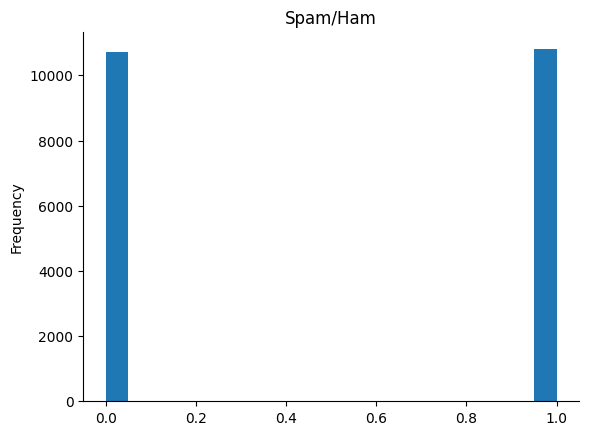

In [ ]:
from matplotlib import pyplot as plt
train_data['Spam/Ham'].plot(kind='hist', bins=20, title='Spam/Ham')
plt.gca().spines[['top', 'right',]].set_visible(False)

**visualizzazione dei dati di validazione**

In [ ]:
val_data

,Text,Spam/Ham
0,new power ##mo ##d 97 xl ##s marty absolutely ...,0
1,start date 1 15 02 hour ##ah ##ead hour 2 star...,0
2,spa ##m mail warn notification attachment remo...,1
3,computer file protection dear hulk ##j ##r wan...,1
4,confirmation order automatic confirmation _ co...,0
...,...,...
4961,hp ##l expense contract f ##yi call question t...,0
4962,urgent please dr dan nk ##anga zenith internat...,1
4963,cheap online tablet shu ##nt willow ##y ti ##t...,1
4964,interview schedule _ connector _ greg mi ##kk ...,0


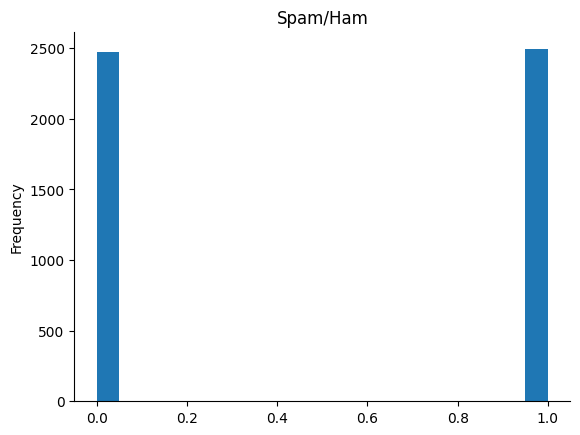

In [ ]:
from matplotlib import pyplot as plt
val_data['Spam/Ham'].plot(kind='hist', bins=20, title='Spam/Ham')
plt.gca().spines[['top', 'right',]].set_visible(False)

**visualizzazione dei dati di test**

In [ ]:
test_data

,Text,Spam/Ham
0,rag hard erection formula herbal alternative _...,1
1,brent note sally rough draft note visit yester...,0
2,commodity logic leslie reef work _ connector _...,0
3,start date 1 14 02 hour ##ah ##ead hour 13 sta...,0
4,cheap pharmacy rc would like cheap overseas dr...,1
...,...,...
6617,98 63 ##7 ##3 go 98 63 ##7 ##3 sit ##ara deal ...,0
6618,inn ##ume ##rable 88 vic ##od ##in professor g...,1
6619,ad ##b proposal zu ##ma chris 20 ##a crescent ...,1
6620,f ##w status plan revision hi louise attach sc...,0


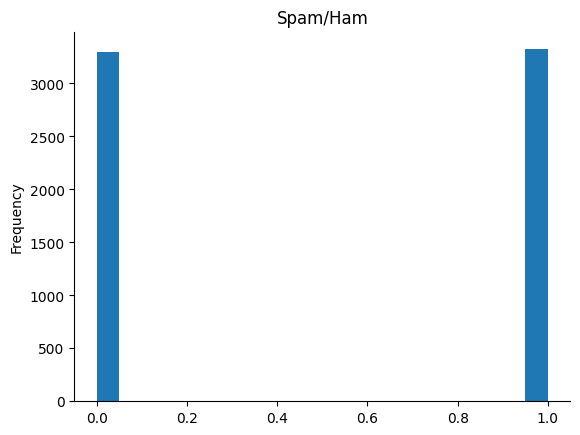

In [ ]:
from matplotlib import pyplot as plt
test_data['Spam/Ham'].plot(kind='hist', bins=20, title='Spam/Ham')
plt.gca().spines[['top', 'right',]].set_visible(False)

# Model Definition

Caricamento del modello DistilBert per la classificazione di sequenze in versione pre-trained.

Il modello, una versione "distillata" di Bert (rete ampiamente utilizzata nell'elaborazione di dati testuali), è stato scelto per via delle sue dimensioni più ridotte che si traducono in un tempo di addestramento minore senza tuttavia penalizzare le prestazioni.

In [ ]:
model_name = 'distilbert-base-uncased'
model = DistilBertForSequenceClassification.from_pretrained(model_name, num_labels=2).to(device)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


1.   Sostituzione del livello di classificazione (Linear) con una sequenza composta da un livello di attivazione ReLu, un livello di Dropout ed un livello lineare
2.   Blocco dell'addestramento dei livelli di feature extraction della rete

In [ ]:
# Replace the last layer for binary classification
num_ftrs = model.classifier.out_features                                        # Number of output features from the penultimate layer
# Replace the classifier layer
model.classifier = nn.Sequential( nn.ReLU(),
                                  nn.Dropout(0.2),
                                  nn.Linear(model.classifier.in_features, 2).to(device)
                                  )
# Freeze all layers except the classifier layer
for name, param in model.named_parameters():
    if 'classifier' not in name:
        param.requires_grad = False

Caricamento del vocabolario ottenuto dalla funzione di tokenizzazione di Bert

In [ ]:
def get_vocab_from_model(model_name):
    tokenizer = DistilBertTokenizer.from_pretrained(model_name)
    return tokenizer.get_vocab()

vocab = get_vocab_from_model(model_name)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

# DataLoader Train e Validation

**Definizione della classe per la gestione del set di dati**


1.   Prelievo dei singoli token e della classe da ogni istanza
2.   Per ogni istanza, associazione di un id posizionale ad ogni singolo token



In [ ]:
class DistilBERTDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, max_len, model_name):
        self.tokenizer = DistilBertTokenizer.from_pretrained(model_name)

        dataframe['Text'] = dataframe['Text'].fillna('').astype(str)

        sentences = dataframe['Text']
        labels = dataframe['Spam/Ham']

        all_tokens = [self.tokenizer.tokenize(s) for s in sentences]

        self.labels = torch.tensor(labels.values, dtype=torch.long)
        self.max_len = max_len
        self.all_token_ids, self.valid_lens = self._preprocess(all_tokens)
        print('Read ' + str(len(self.all_token_ids)) + ' examples')

    def _preprocess(self, all_tokens):
        pool = multiprocessing.Pool(4)  # Use 4 worker processes
        out = pool.map(self._mp_worker, all_tokens)
        all_token_ids = [token_ids for token_ids, valid_len in out]
        valid_lens = [valid_len for token_ids, valid_len in out]
        return (torch.tensor(all_token_ids, dtype=torch.long),
                torch.tensor(valid_lens, dtype=torch.long))

    def _mp_worker(self, tokens):
        self._truncate_tokens(tokens)
        token_ids = self.tokenizer.convert_tokens_to_ids(tokens)
        token_ids += [self.tokenizer.pad_token_id] * (self.max_len - len(token_ids))
        valid_len = len(tokens)
        return token_ids, valid_len

    def _truncate_tokens(self, tokens):
        while len(tokens) > self.max_len - 2:
            tokens.pop()

    def __getitem__(self, idx):
        input_tensor = self.all_token_ids[idx]
        valid_len_tensor = self.valid_lens[idx]
        label_tensor = self.labels[idx]
        return (input_tensor, valid_len_tensor), label_tensor

    def __len__(self):
        return len(self.all_token_ids)

Prelievo dei set di dati per il train e la validation dai file CSV su cui sono stati precedentemente memorizzati

In [ ]:
train_data = pd.read_csv(TRAIN_PATH)
val_data = pd.read_csv(VAL_PATH)

Caricamento dei set di dati mediante la funzione DataLoader disponibile per le istanze della classe sopra definita

In [ ]:
batch_size = 512
max_len = 128

train_set = DistilBERTDataset(train_data, max_len, model_name)
val_set = DistilBERTDataset(val_data, max_len, model_name)

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Read 21519 examples


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Read 4966 examples


In [ ]:
train_dataloader = torch.utils.data.DataLoader(train_set, batch_size, shuffle=True,num_workers=2)
val_dataloader = torch.utils.data.DataLoader(val_set, batch_size, shuffle=True,num_workers=2)

# Training con Validation

Definizione della funzione di addestramento della rete con i set di dati di train e validation per l'individuazione degli iper-parametri ottimali per l'addestramento finale.

In [ ]:
def train_loop_validation(train_dataloader, val_dataloader, startEpoch, numEpochs, model_conv, criterion, optimizer, best_acc, best_loss, best_epoca, outputPath, scheduler=None):

    train_files = ['lossTrain.txt', 'AccTrain.txt', 'lossVal.txt', 'AccVal.txt']
    for filename in train_files:
        filepath = os.path.join(outputPath, filename)
        if os.path.exists(filepath):
            os.remove(filepath)

    for epoch in range(startEpoch, numEpochs + 1):
        since = time.time()

        modelLoss_train = 0.0
        modelAcc_train = 0.0

        model_conv.train()
        totalSize = 0

        # Training loop
        for batch in tqdm(train_dataloader, total=len(train_dataloader), desc=f"Epoch {epoch}/{numEpochs} - Training"):
            (inputs, valid_lens), labels = batch

            inputs = inputs.to(device)
            valid_lens = valid_lens.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            # Forward pass
            outputs = model_conv(inputs)
            logits = outputs.logits  # Access logits from SequenceClassifierOutput
            loss = criterion(logits, labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            modelLoss_train += loss.item() * inputs.size(0)
            _, preds = torch.max(logits, 1)
            modelAcc_train += (preds == labels).sum().item()
            totalSize += inputs.size(0)

        epoch_loss = modelLoss_train / totalSize
        epoch_acc = modelAcc_train / totalSize

        # Validation loop
        model_conv.eval()
        modelLoss_val = 0.0
        modelAcc_val = 0.0
        totalSize_val = 0

        with torch.no_grad():
            for batch in tqdm(val_dataloader, total=len(val_dataloader), desc=f"Epoch {epoch}/{numEpochs} - Validation"):
                (inputs, valid_lens), labels = batch

                inputs = inputs.to(device)
                valid_lens = valid_lens.to(device)
                labels = labels.to(device)  # No need for .view(-1, 1) and .float()

                outputs = model_conv(inputs)
                logits = outputs.logits  # Access logits from SequenceClassifierOutput
                loss = criterion(logits, labels)

                modelLoss_val += loss.item() * inputs.size(0)
                _, preds = torch.max(logits, 1)
                modelAcc_val += (preds == labels).sum().item()
                totalSize_val += inputs.size(0)

        val_loss = modelLoss_val / totalSize_val
        val_acc = modelAcc_val / totalSize_val

        time_elapsed = time.time() - since
        current_lr = optimizer.param_groups[0]['lr']

        print('[Epoch %d][TRAIN on %d [Loss: %.4f  ACC: %.4f]][VAL on %d [Loss: %.4f  ACC: %.4f]][TIME: %.0f m %.0f s] [LR: %.5f]'
              % (epoch, totalSize, epoch_loss, epoch_acc, totalSize_val, val_loss, val_acc, time_elapsed // 60, time_elapsed % 60, current_lr))

        if val_acc > best_acc or (val_acc == best_acc and val_loss < best_loss):
            best_acc = val_acc
            best_loss = val_loss
            best_epoca = epoch
            print('     .... Saving best weights ....')
            torch.save(model_conv.state_dict(), os.path.join(outputPath, 'best_model_weights.pth'))

        with open(os.path.join(outputPath, 'lossTrain.txt'), 'a') as f:
            f.write(f'{epoch_loss}\n')
        with open(os.path.join(outputPath, 'AccTrain.txt'), 'a') as f:
            f.write(f'{epoch_acc}\n')
        with open(os.path.join(outputPath, 'lossVal.txt'), 'a') as f:
            f.write(f'{val_loss}\n')
        with open(os.path.join(outputPath, 'AccVal.txt'), 'a') as f:
            f.write(f'{val_acc}\n')

        if scheduler:
            scheduler.step(val_loss)

    return best_epoca

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") #vedo se la GPU è disponibile

#gia stato fatto in model definition
model = DistilBertForSequenceClassification.from_pretrained(model_name, num_labels=2).to(device)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Settaggio degli iper-parametri

In [ ]:
# Updated hyperparameters
learning_rate = 0.0008                                                           # Learning rate for the optimizer
num_epochs = 40                                                                 # Total number of epochs for training
startEpoch = 1                                                                  # Initial epoch (useful for resuming interrupted training)
best_acc = 0.0                                                                  # Initial best accuracy (to track the best model)
best_loss = float('inf')                                                        # Initial best loss (to track the best model)
best_epoch = -1                                                                 # Epoch corresponding to the best saved model

**Preparazione del modello per l'addestramento**


1.   Scelta della funzione di perdita (CrossEntropy) e dell'ottimizzatore (AdamW)



In [ ]:
# Define criterion and optimizer
criterion = nn.CrossEntropyLoss().to(device) #scelgo come loss function la CrossEntropy()
optimizer = AdamW(model.parameters(), lr=learning_rate, correct_bias=False) #scelgo AdamW come ottimizzatore

Addestramento della rete

In [ ]:
# Call the training function with validation
best_epoch = train_loop_validation(train_dataloader, val_dataloader, startEpoch, num_epochs, model, criterion, optimizer, best_acc, best_loss, best_epoch, WEIGHTS_PATH)

Epoch 1/40 - Validation: 100%|██████████| 10/10 [00:17<00:00,  1.73s/it]


[Epoch 1][TRAIN on 21519 [Loss: 0.5232  ACC: 0.7146]][VAL on 4966 [Loss: 0.5280  ACC: 0.7191]][TIME: 1 m 35 s] [LR: 0.00080]
     .... Saving best weights ....


Epoch 2/40 - Validation: 100%|██████████| 10/10 [00:17<00:00,  1.74s/it]


[Epoch 2][TRAIN on 21519 [Loss: 0.3794  ACC: 0.8182]][VAL on 4966 [Loss: 0.3373  ACC: 0.8598]][TIME: 1 m 35 s] [LR: 0.00080]
     .... Saving best weights ....


Epoch 3/40 - Validation: 100%|██████████| 10/10 [00:17<00:00,  1.74s/it]


[Epoch 3][TRAIN on 21519 [Loss: 0.3343  ACC: 0.8467]][VAL on 4966 [Loss: 0.3506  ACC: 0.7968]][TIME: 1 m 34 s] [LR: 0.00080]


Epoch 4/40 - Validation: 100%|██████████| 10/10 [00:17<00:00,  1.75s/it]


[Epoch 4][TRAIN on 21519 [Loss: 0.3160  ACC: 0.8557]][VAL on 4966 [Loss: 0.2839  ACC: 0.8905]][TIME: 1 m 34 s] [LR: 0.00080]
     .... Saving best weights ....


Epoch 5/40 - Validation: 100%|██████████| 10/10 [00:17<00:00,  1.75s/it]


[Epoch 5][TRAIN on 21519 [Loss: 0.3074  ACC: 0.8624]][VAL on 4966 [Loss: 0.3527  ACC: 0.7942]][TIME: 1 m 35 s] [LR: 0.00080]


Epoch 6/40 - Validation: 100%|██████████| 10/10 [00:17<00:00,  1.74s/it]


[Epoch 6][TRAIN on 21519 [Loss: 0.3045  ACC: 0.8619]][VAL on 4966 [Loss: 0.2975  ACC: 0.8397]][TIME: 1 m 34 s] [LR: 0.00080]


Epoch 7/40 - Validation: 100%|██████████| 10/10 [00:17<00:00,  1.73s/it]


[Epoch 7][TRAIN on 21519 [Loss: 0.2928  ACC: 0.8715]][VAL on 4966 [Loss: 0.2617  ACC: 0.9029]][TIME: 1 m 34 s] [LR: 0.00080]
     .... Saving best weights ....


Epoch 8/40 - Validation: 100%|██████████| 10/10 [00:17<00:00,  1.72s/it]


[Epoch 8][TRAIN on 21519 [Loss: 0.2877  ACC: 0.8735]][VAL on 4966 [Loss: 0.2787  ACC: 0.8707]][TIME: 1 m 34 s] [LR: 0.00080]


Epoch 9/40 - Validation: 100%|██████████| 10/10 [00:17<00:00,  1.74s/it]


[Epoch 9][TRAIN on 21519 [Loss: 0.2827  ACC: 0.8780]][VAL on 4966 [Loss: 0.2701  ACC: 0.8800]][TIME: 1 m 34 s] [LR: 0.00080]


Epoch 10/40 - Validation: 100%|██████████| 10/10 [00:17<00:00,  1.74s/it]


[Epoch 10][TRAIN on 21519 [Loss: 0.2751  ACC: 0.8826]][VAL on 4966 [Loss: 0.2462  ACC: 0.9011]][TIME: 1 m 34 s] [LR: 0.00080]


Epoch 11/40 - Validation: 100%|██████████| 10/10 [00:17<00:00,  1.75s/it]


[Epoch 11][TRAIN on 21519 [Loss: 0.2725  ACC: 0.8788]][VAL on 4966 [Loss: 0.2805  ACC: 0.8621]][TIME: 1 m 34 s] [LR: 0.00080]


Epoch 12/40 - Validation: 100%|██████████| 10/10 [00:17<00:00,  1.75s/it]


[Epoch 12][TRAIN on 21519 [Loss: 0.2873  ACC: 0.8737]][VAL on 4966 [Loss: 0.2731  ACC: 0.8768]][TIME: 1 m 34 s] [LR: 0.00080]


Epoch 13/40 - Validation: 100%|██████████| 10/10 [00:17<00:00,  1.74s/it]


[Epoch 13][TRAIN on 21519 [Loss: 0.2721  ACC: 0.8821]][VAL on 4966 [Loss: 0.2361  ACC: 0.9128]][TIME: 1 m 34 s] [LR: 0.00080]
     .... Saving best weights ....


Epoch 14/40 - Validation: 100%|██████████| 10/10 [00:17<00:00,  1.74s/it]


[Epoch 14][TRAIN on 21519 [Loss: 0.2645  ACC: 0.8855]][VAL on 4966 [Loss: 0.2420  ACC: 0.8979]][TIME: 1 m 34 s] [LR: 0.00080]


Epoch 15/40 - Validation: 100%|██████████| 10/10 [00:17<00:00,  1.75s/it]


[Epoch 15][TRAIN on 21519 [Loss: 0.2681  ACC: 0.8838]][VAL on 4966 [Loss: 0.2695  ACC: 0.8693]][TIME: 1 m 34 s] [LR: 0.00080]


Epoch 16/40 - Validation: 100%|██████████| 10/10 [00:17<00:00,  1.76s/it]


[Epoch 16][TRAIN on 21519 [Loss: 0.2615  ACC: 0.8869]][VAL on 4966 [Loss: 0.2247  ACC: 0.9152]][TIME: 1 m 34 s] [LR: 0.00080]
     .... Saving best weights ....


Epoch 17/40 - Validation: 100%|██████████| 10/10 [00:17<00:00,  1.76s/it]


[Epoch 17][TRAIN on 21519 [Loss: 0.2606  ACC: 0.8864]][VAL on 4966 [Loss: 0.2201  ACC: 0.9168]][TIME: 1 m 34 s] [LR: 0.00080]
     .... Saving best weights ....


Epoch 18/40 - Validation: 100%|██████████| 10/10 [00:17<00:00,  1.75s/it]


[Epoch 18][TRAIN on 21519 [Loss: 0.2574  ACC: 0.8891]][VAL on 4966 [Loss: 0.2267  ACC: 0.9094]][TIME: 1 m 35 s] [LR: 0.00080]


Epoch 19/40 - Validation: 100%|██████████| 10/10 [00:17<00:00,  1.75s/it]


[Epoch 19][TRAIN on 21519 [Loss: 0.2599  ACC: 0.8871]][VAL on 4966 [Loss: 0.2651  ACC: 0.8691]][TIME: 1 m 34 s] [LR: 0.00080]


Epoch 20/40 - Validation: 100%|██████████| 10/10 [00:17<00:00,  1.75s/it]


[Epoch 20][TRAIN on 21519 [Loss: 0.2591  ACC: 0.8872]][VAL on 4966 [Loss: 0.2508  ACC: 0.8828]][TIME: 1 m 34 s] [LR: 0.00080]


Epoch 21/40 - Validation: 100%|██████████| 10/10 [00:17<00:00,  1.75s/it]


[Epoch 21][TRAIN on 21519 [Loss: 0.2528  ACC: 0.8905]][VAL on 4966 [Loss: 0.2201  ACC: 0.9168]][TIME: 1 m 34 s] [LR: 0.00080]
     .... Saving best weights ....


Epoch 22/40 - Validation: 100%|██████████| 10/10 [00:17<00:00,  1.74s/it]


[Epoch 22][TRAIN on 21519 [Loss: 0.2487  ACC: 0.8924]][VAL on 4966 [Loss: 0.2456  ACC: 0.8884]][TIME: 1 m 34 s] [LR: 0.00080]


Epoch 23/40 - Validation: 100%|██████████| 10/10 [00:17<00:00,  1.74s/it]


[Epoch 23][TRAIN on 21519 [Loss: 0.2489  ACC: 0.8922]][VAL on 4966 [Loss: 0.2162  ACC: 0.9199]][TIME: 1 m 34 s] [LR: 0.00080]
     .... Saving best weights ....


Epoch 24/40 - Validation: 100%|██████████| 10/10 [00:17<00:00,  1.73s/it]


[Epoch 24][TRAIN on 21519 [Loss: 0.2479  ACC: 0.8923]][VAL on 4966 [Loss: 0.2263  ACC: 0.9124]][TIME: 1 m 34 s] [LR: 0.00080]


Epoch 25/40 - Validation: 100%|██████████| 10/10 [00:17<00:00,  1.73s/it]


[Epoch 25][TRAIN on 21519 [Loss: 0.2552  ACC: 0.8892]][VAL on 4966 [Loss: 0.2599  ACC: 0.8701]][TIME: 1 m 34 s] [LR: 0.00080]


Epoch 26/40 - Validation: 100%|██████████| 10/10 [00:17<00:00,  1.73s/it]


[Epoch 26][TRAIN on 21519 [Loss: 0.2548  ACC: 0.8895]][VAL on 4966 [Loss: 0.2225  ACC: 0.9160]][TIME: 1 m 34 s] [LR: 0.00080]


Epoch 27/40 - Validation: 100%|██████████| 10/10 [00:17<00:00,  1.74s/it]


[Epoch 27][TRAIN on 21519 [Loss: 0.2523  ACC: 0.8941]][VAL on 4966 [Loss: 0.2159  ACC: 0.9120]][TIME: 1 m 34 s] [LR: 0.00080]


Epoch 28/40 - Validation: 100%|██████████| 10/10 [00:17<00:00,  1.75s/it]


[Epoch 28][TRAIN on 21519 [Loss: 0.2505  ACC: 0.8932]][VAL on 4966 [Loss: 0.2085  ACC: 0.9225]][TIME: 1 m 34 s] [LR: 0.00080]
     .... Saving best weights ....


Epoch 29/40 - Validation: 100%|██████████| 10/10 [00:17<00:00,  1.74s/it]


[Epoch 29][TRAIN on 21519 [Loss: 0.2391  ACC: 0.8977]][VAL on 4966 [Loss: 0.2171  ACC: 0.9082]][TIME: 1 m 34 s] [LR: 0.00080]


Epoch 30/40 - Validation: 100%|██████████| 10/10 [00:17<00:00,  1.74s/it]


[Epoch 30][TRAIN on 21519 [Loss: 0.2390  ACC: 0.8994]][VAL on 4966 [Loss: 0.2026  ACC: 0.9229]][TIME: 1 m 34 s] [LR: 0.00080]
     .... Saving best weights ....


Epoch 31/40 - Validation: 100%|██████████| 10/10 [00:17<00:00,  1.75s/it]


[Epoch 31][TRAIN on 21519 [Loss: 0.2444  ACC: 0.8925]][VAL on 4966 [Loss: 0.2158  ACC: 0.9080]][TIME: 1 m 34 s] [LR: 0.00080]


Epoch 32/40 - Validation: 100%|██████████| 10/10 [00:17<00:00,  1.76s/it]


[Epoch 32][TRAIN on 21519 [Loss: 0.2370  ACC: 0.8999]][VAL on 4966 [Loss: 0.2101  ACC: 0.9180]][TIME: 1 m 35 s] [LR: 0.00080]


Epoch 33/40 - Validation: 100%|██████████| 10/10 [00:17<00:00,  1.76s/it]


[Epoch 33][TRAIN on 21519 [Loss: 0.2390  ACC: 0.8986]][VAL on 4966 [Loss: 0.2178  ACC: 0.9078]][TIME: 1 m 34 s] [LR: 0.00080]


Epoch 34/40 - Validation: 100%|██████████| 10/10 [00:17<00:00,  1.75s/it]


[Epoch 34][TRAIN on 21519 [Loss: 0.2383  ACC: 0.8992]][VAL on 4966 [Loss: 0.2216  ACC: 0.8999]][TIME: 1 m 35 s] [LR: 0.00080]


Epoch 35/40 - Validation: 100%|██████████| 10/10 [00:17<00:00,  1.74s/it]


[Epoch 35][TRAIN on 21519 [Loss: 0.2399  ACC: 0.8955]][VAL on 4966 [Loss: 0.2287  ACC: 0.9092]][TIME: 1 m 34 s] [LR: 0.00080]


Epoch 36/40 - Validation: 100%|██████████| 10/10 [00:17<00:00,  1.75s/it]


[Epoch 36][TRAIN on 21519 [Loss: 0.2444  ACC: 0.8934]][VAL on 4966 [Loss: 0.2088  ACC: 0.9197]][TIME: 1 m 34 s] [LR: 0.00080]


Epoch 37/40 - Validation: 100%|██████████| 10/10 [00:17<00:00,  1.75s/it]


[Epoch 37][TRAIN on 21519 [Loss: 0.2411  ACC: 0.8962]][VAL on 4966 [Loss: 0.2130  ACC: 0.9110]][TIME: 1 m 35 s] [LR: 0.00080]


Epoch 38/40 - Validation: 100%|██████████| 10/10 [00:17<00:00,  1.76s/it]


[Epoch 38][TRAIN on 21519 [Loss: 0.2374  ACC: 0.8999]][VAL on 4966 [Loss: 0.2179  ACC: 0.9070]][TIME: 1 m 35 s] [LR: 0.00080]


Epoch 39/40 - Validation: 100%|██████████| 10/10 [00:17<00:00,  1.75s/it]


[Epoch 39][TRAIN on 21519 [Loss: 0.2423  ACC: 0.8971]][VAL on 4966 [Loss: 0.2182  ACC: 0.9050]][TIME: 1 m 34 s] [LR: 0.00080]


Epoch 40/40 - Validation: 100%|██████████| 10/10 [00:17<00:00,  1.75s/it]

[Epoch 40][TRAIN on 21519 [Loss: 0.2346  ACC: 0.8998]][VAL on 4966 [Loss: 0.2028  ACC: 0.9130]][TIME: 1 m 35 s] [LR: 0.00080]


# Metrics Plot

**Visualizzazione dell'andamento dell'addestramento**


1.   Confronto tra la curva di loss ottenuta nel train e quella ottenuta nella validation
2.   Confronto tra la curva di accuracy ottenuta nel train e quella ottenuta nella validation



In [ ]:
# Initialization of lists for losses and accuracies
loss_model_train = []
loss_model_val = []
acc_model_train = []
acc_model_val = []

# Reading training loss files
loss_train_path = os.path.join(WEIGHTS_PATH, 'lossTrain.txt')
with open(loss_train_path, 'r') as file:
    loss_model_train = [float(line.strip()) for line in file.readlines()]

# Reading validation loss files
loss_val_path = os.path.join(WEIGHTS_PATH, 'lossVal.txt')
with open(loss_val_path, 'r') as file:
    loss_model_val = [float(line.strip()) for line in file.readlines()]

# Plotting training and validation losses
plt.figure()
plt.title("Model: Training Vs Validation Losses")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(range(1, len(loss_model_train) + 1), loss_model_train, color='r', label="Training Loss")
plt.plot(range(1, len(loss_model_val) + 1), loss_model_val, color='g', label="Validation Loss")
plt.legend()
plt.savefig(os.path.join(WEIGHTS_PATH, 'LossTrainVal.png'))

# Reading training accuracy files
acc_train_path = os.path.join(WEIGHTS_PATH, 'AccTrain.txt')
with open(acc_train_path, 'r') as file:
    acc_model_train = [float(line.strip()) for line in file.readlines()]

# Reading validation accuracy files
acc_val_path = os.path.join(WEIGHTS_PATH, 'AccVal.txt')
with open(acc_val_path, 'r') as file:
    acc_model_val = [float(line.strip()) for line in file.readlines()]

# Plotting training and validation accuracies
plt.figure()
plt.title("Training Vs Validation Accuracies")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.plot(range(1, len(acc_model_train) + 1), acc_model_train, color='r', label="Training Accuracy")
plt.plot(range(1, len(acc_model_val) + 1), acc_model_val, color='g', label="Validation Accuracy")
plt.legend()
plt.savefig(os.path.join(WEIGHTS_PATH, 'AccTrainVal.png'))

# Dataloader Dataset

**Definizione della classe per la gestione del set di dati**


1.   Prelievo dei singoli token e della classe da ogni istanza
2.   Per ogni istanza, associazione di un id posizionale ad ogni singolo token



In [ ]:
class DistilBERTDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, max_len, model_name):
        self.tokenizer = DistilBertTokenizer.from_pretrained(model_name)

        dataframe['Text'] = dataframe['Text'].fillna('').astype(str)

        sentences = dataframe['Text']
        labels = dataframe['Spam/Ham']

        all_tokens = [self.tokenizer.tokenize(s) for s in sentences]

        self.labels = torch.tensor(labels.values, dtype=torch.long)
        self.max_len = max_len
        self.all_token_ids, self.valid_lens = self._preprocess(all_tokens)
        print('Read ' + str(len(self.all_token_ids)) + ' examples')

    def _preprocess(self, all_tokens):
        pool = multiprocessing.Pool(4)  # Use 4 worker processes
        out = pool.map(self._mp_worker, all_tokens)
        all_token_ids = [token_ids for token_ids, valid_len in out]
        valid_lens = [valid_len for token_ids, valid_len in out]
        return (torch.tensor(all_token_ids, dtype=torch.long),
                torch.tensor(valid_lens, dtype=torch.long))

    def _mp_worker(self, tokens):
        self._truncate_tokens(tokens)
        token_ids = self.tokenizer.convert_tokens_to_ids(tokens)
        token_ids += [self.tokenizer.pad_token_id] * (self.max_len - len(token_ids))
        valid_len = len(tokens)
        return token_ids, valid_len

    def _truncate_tokens(self, tokens):
        while len(tokens) > self.max_len - 2:
            tokens.pop()

    def __getitem__(self, idx):
        input_tensor = self.all_token_ids[idx]
        valid_len_tensor = self.valid_lens[idx]
        label_tensor = self.labels[idx]
        return (input_tensor, valid_len_tensor), label_tensor

    def __len__(self):
        return len(self.all_token_ids)

**Gestione del set di dati per l'addestramento**

1.   Creazione del set di dati di train finale mediante la concatenzione dei due set di dati utilizzati precedentemente per l'addestramento con dataset di train e validation.
2.   Salvataggio del nuovo set di dati in formato CSV



In [ ]:
# Leggi i dati dai file CSV
train_data = pd.read_csv(TRAIN_PATH)
val_data = pd.read_csv(VAL_PATH)

# Unisci i due DataFrame
combined_data = pd.concat([train_data, val_data], ignore_index=True)

# Fai lo shuffle del DataFrame combinato
shuffled_data = combined_data.sample(frac=1).reset_index(drop=True)

# Salva il DataFrame combinato e mescolato al percorso specificato
shuffled_data.to_csv(TRAIN_FINAL_PATH, index=False)

Caricamento dei set di dati mediante la funzione DataLoader disponibile per le istanze della classe sopra definita

In [ ]:
batch_size = 512
max_len = 128

final_train_data = pd.read_csv(TRAIN_FINAL_PATH)

final_train_set = DistilBERTDataset(final_train_data, max_len, model_name)
final_train_dataloader = torch.utils.data.DataLoader(final_train_set, batch_size, shuffle=True,num_workers=2)

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Read 26485 examples


# Training

Definizione della funzione di addestramento della rete con il solo set di dati di train da usare per l'addestramento finale.

In [ ]:
def train_loop(train_dataloader, startEpoch, numEpochs, model_conv, criterion, optimizer, outputPath, scheduler=None):

    train_files = ['lossTrain.txt', 'AccTrain.txt']
    for filename in train_files:
        filepath = os.path.join(outputPath, filename)
        if os.path.exists(filepath):
            os.remove(filepath)

    for epoch in range(startEpoch, numEpochs + 1):
        since = time.time()

        modelLoss_train = 0.0
        modelAcc_train = 0.0

        model_conv.train()
        totalSize = 0

        # Training loop
        for batch in tqdm(train_dataloader, total=len(train_dataloader), desc=f"Epoch {epoch}/{numEpochs} - Training"):
            (inputs, valid_lens), labels = batch

            inputs = inputs.to(device)
            valid_lens = valid_lens.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            # Forward pass
            outputs = model_conv(inputs)
            logits = outputs.logits  # Access logits from the SequenceClassifierOutput object
            loss = criterion(logits, labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            modelLoss_train += loss.item() * inputs.size(0)
            _, preds = torch.max(logits, 1)
            modelAcc_train += (preds == labels).sum().item()
            totalSize += inputs.size(0)

        epoch_loss = modelLoss_train / totalSize
        epoch_acc = modelAcc_train / totalSize

        time_elapsed = time.time() - since
        current_lr = optimizer.param_groups[0]['lr']

        print('[Epoch %d][TRAIN on %d [Loss: %.4f  ACC: %.4f]][TIME: %.0f m %.0f s] [LR: %.5f]'
              % (epoch, totalSize, epoch_loss, epoch_acc, time_elapsed // 60, time_elapsed % 60, current_lr))

        # Save weights after each epoch, overwriting them
        torch.save(model_conv.state_dict(), os.path.join(outputPath, 'weights.pth'))

        with open(os.path.join(outputPath, 'lossTrain.txt'), 'a') as f:
            f.write(f'{epoch_loss}\n')
        with open(os.path.join(outputPath, 'AccTrain.txt'), 'a') as f:
            f.write(f'{epoch_acc}\n')

        if scheduler:
            scheduler.step(epoch_loss)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#già fatto in model definition
model = DistilBertForSequenceClassification.from_pretrained(model_name, num_labels=2).to(device)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Settaggio degli iper-parametri

In [ ]:
# Updated hyperparameters
learning_rate = 0.0008                                                          # Learning rate for the optimizer
num_epochs = 30                                                                 # Total number of epochs for training
startEpoch = 1                                                                  # Initial epoch (useful for resuming interrupted training)
best_acc = 0.0                                                                  # Initial best accuracy (to track the best model)
best_loss = float('inf')                                                        # Initial best loss (to track the best model)
best_epoch = -1                                                                 # Epoch corresponding to the best saved model

**Preparazione del modello per l'addestramento**

1.  Scelta della funzione di perdita (CrossEntropy) e dell'ottimizzatore (AdamW)



In [ ]:
# Define criterion and optimizer
criterion = nn.CrossEntropyLoss().to(device)
optimizer = AdamW(model.parameters(), lr=learning_rate, correct_bias=False)

Addestramento della rete

In [ ]:
# Call the training function
train_loop(final_train_dataloader, startEpoch, num_epochs, model, criterion, optimizer, BEST_WEIGHT_PATH)

Epoch 1/30 - Training: 100%|██████████| 52/52 [01:39<00:00,  1.91s/it]


[Epoch 1][TRAIN on 26485 [Loss: 0.5208  ACC: 0.7128]][TIME: 1 m 39 s] [LR: 0.00080]


Epoch 2/30 - Training: 100%|██████████| 52/52 [01:39<00:00,  1.91s/it]


[Epoch 2][TRAIN on 26485 [Loss: 0.3433  ACC: 0.8374]][TIME: 1 m 39 s] [LR: 0.00080]


Epoch 3/30 - Training: 100%|██████████| 52/52 [01:39<00:00,  1.91s/it]


[Epoch 3][TRAIN on 26485 [Loss: 0.3252  ACC: 0.8509]][TIME: 1 m 39 s] [LR: 0.00080]


Epoch 4/30 - Training: 100%|██████████| 52/52 [01:39<00:00,  1.91s/it]


[Epoch 4][TRAIN on 26485 [Loss: 0.3030  ACC: 0.8675]][TIME: 1 m 39 s] [LR: 0.00080]


Epoch 5/30 - Training: 100%|██████████| 52/52 [01:39<00:00,  1.91s/it]


[Epoch 5][TRAIN on 26485 [Loss: 0.2958  ACC: 0.8689]][TIME: 1 m 39 s] [LR: 0.00080]


Epoch 6/30 - Training: 100%|██████████| 52/52 [01:39<00:00,  1.92s/it]


[Epoch 6][TRAIN on 26485 [Loss: 0.2850  ACC: 0.8743]][TIME: 1 m 40 s] [LR: 0.00080]


Epoch 7/30 - Training: 100%|██████████| 52/52 [01:38<00:00,  1.90s/it]


[Epoch 7][TRAIN on 26485 [Loss: 0.2739  ACC: 0.8821]][TIME: 1 m 39 s] [LR: 0.00080]


Epoch 8/30 - Training: 100%|██████████| 52/52 [01:39<00:00,  1.91s/it]


[Epoch 8][TRAIN on 26485 [Loss: 0.2734  ACC: 0.8818]][TIME: 1 m 39 s] [LR: 0.00080]


Epoch 9/30 - Training: 100%|██████████| 52/52 [01:38<00:00,  1.90s/it]


[Epoch 9][TRAIN on 26485 [Loss: 0.2688  ACC: 0.8827]][TIME: 1 m 39 s] [LR: 0.00080]


Epoch 10/30 - Training: 100%|██████████| 52/52 [01:39<00:00,  1.91s/it]


[Epoch 10][TRAIN on 26485 [Loss: 0.2662  ACC: 0.8834]][TIME: 1 m 39 s] [LR: 0.00080]


Epoch 11/30 - Training: 100%|██████████| 52/52 [01:39<00:00,  1.91s/it]


[Epoch 11][TRAIN on 26485 [Loss: 0.2572  ACC: 0.8896]][TIME: 1 m 39 s] [LR: 0.00080]


Epoch 12/30 - Training: 100%|██████████| 52/52 [01:39<00:00,  1.91s/it]


[Epoch 12][TRAIN on 26485 [Loss: 0.2626  ACC: 0.8843]][TIME: 1 m 39 s] [LR: 0.00080]


Epoch 13/30 - Training: 100%|██████████| 52/52 [01:39<00:00,  1.91s/it]


[Epoch 13][TRAIN on 26485 [Loss: 0.2529  ACC: 0.8903]][TIME: 1 m 39 s] [LR: 0.00080]


Epoch 14/30 - Training: 100%|██████████| 52/52 [01:39<00:00,  1.91s/it]


[Epoch 14][TRAIN on 26485 [Loss: 0.2506  ACC: 0.8928]][TIME: 1 m 39 s] [LR: 0.00080]


Epoch 15/30 - Training: 100%|██████████| 52/52 [01:39<00:00,  1.91s/it]


[Epoch 15][TRAIN on 26485 [Loss: 0.2497  ACC: 0.8926]][TIME: 1 m 39 s] [LR: 0.00080]


Epoch 16/30 - Training: 100%|██████████| 52/52 [01:39<00:00,  1.91s/it]


[Epoch 16][TRAIN on 26485 [Loss: 0.2455  ACC: 0.8945]][TIME: 1 m 40 s] [LR: 0.00080]


Epoch 17/30 - Training: 100%|██████████| 52/52 [01:39<00:00,  1.91s/it]


[Epoch 17][TRAIN on 26485 [Loss: 0.2480  ACC: 0.8928]][TIME: 1 m 39 s] [LR: 0.00080]


Epoch 18/30 - Training: 100%|██████████| 52/52 [01:39<00:00,  1.91s/it]


[Epoch 18][TRAIN on 26485 [Loss: 0.2427  ACC: 0.8963]][TIME: 1 m 40 s] [LR: 0.00080]


Epoch 19/30 - Training: 100%|██████████| 52/52 [01:39<00:00,  1.91s/it]


[Epoch 19][TRAIN on 26485 [Loss: 0.2449  ACC: 0.8947]][TIME: 1 m 40 s] [LR: 0.00080]


Epoch 20/30 - Training: 100%|██████████| 52/52 [01:39<00:00,  1.91s/it]


[Epoch 20][TRAIN on 26485 [Loss: 0.2416  ACC: 0.8959]][TIME: 1 m 39 s] [LR: 0.00080]


Epoch 21/30 - Training: 100%|██████████| 52/52 [01:39<00:00,  1.91s/it]


[Epoch 21][TRAIN on 26485 [Loss: 0.2358  ACC: 0.9004]][TIME: 1 m 40 s] [LR: 0.00080]


Epoch 22/30 - Training: 100%|██████████| 52/52 [01:39<00:00,  1.91s/it]


[Epoch 22][TRAIN on 26485 [Loss: 0.2429  ACC: 0.8950]][TIME: 1 m 40 s] [LR: 0.00080]


Epoch 23/30 - Training: 100%|██████████| 52/52 [01:39<00:00,  1.91s/it]


[Epoch 23][TRAIN on 26485 [Loss: 0.2353  ACC: 0.8982]][TIME: 1 m 39 s] [LR: 0.00080]


Epoch 24/30 - Training: 100%|██████████| 52/52 [01:39<00:00,  1.90s/it]


[Epoch 24][TRAIN on 26485 [Loss: 0.2354  ACC: 0.8971]][TIME: 1 m 39 s] [LR: 0.00080]


Epoch 25/30 - Training: 100%|██████████| 52/52 [01:39<00:00,  1.91s/it]


[Epoch 25][TRAIN on 26485 [Loss: 0.2327  ACC: 0.9016]][TIME: 1 m 39 s] [LR: 0.00080]


Epoch 26/30 - Training: 100%|██████████| 52/52 [01:39<00:00,  1.91s/it]


[Epoch 26][TRAIN on 26485 [Loss: 0.2285  ACC: 0.9010]][TIME: 1 m 39 s] [LR: 0.00080]


Epoch 27/30 - Training: 100%|██████████| 52/52 [01:39<00:00,  1.91s/it]


[Epoch 27][TRAIN on 26485 [Loss: 0.2303  ACC: 0.9011]][TIME: 1 m 40 s] [LR: 0.00080]


Epoch 28/30 - Training: 100%|██████████| 52/52 [01:39<00:00,  1.91s/it]


[Epoch 28][TRAIN on 26485 [Loss: 0.2250  ACC: 0.9037]][TIME: 1 m 39 s] [LR: 0.00080]


Epoch 29/30 - Training: 100%|██████████| 52/52 [01:39<00:00,  1.91s/it]


[Epoch 29][TRAIN on 26485 [Loss: 0.2267  ACC: 0.9027]][TIME: 1 m 40 s] [LR: 0.00080]


Epoch 30/30 - Training: 100%|██████████| 52/52 [01:39<00:00,  1.91s/it]


[Epoch 30][TRAIN on 26485 [Loss: 0.2226  ACC: 0.9050]][TIME: 1 m 39 s] [LR: 0.00080]


# Testing

Caricamento del modello per il test

In [ ]:
model = DistilBertForSequenceClassification.from_pretrained(model_name, num_labels=2).to(device)

# Replace the last layer for binary classification
num_ftrs = model.classifier.out_features                                        # Number of output features from the penultimate layer
# Replace the classifier layer
model.classifier = nn.Sequential( nn.ReLU(),
                                  nn.Dropout(0.2),
                                  nn.Linear(model.classifier.in_features, 2).to(device)
                                  )

# Define criterion
criterion = nn.CrossEntropyLoss().to(device) #scelgo come loss function la CrossEntropy()

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Caricamento del set di dati di test

In [ ]:
batch_size = 512
max_len = 128

test_data = pd.read_csv(TEST_PATH)
test_set = DistilBERTDataset(test_data, max_len, model_name)
test_dataloader = torch.utils.data.DataLoader(test_set, batch_size, shuffle=True,num_workers=2)

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Read 6622 examples


**Definizione della funzione di test del modello**


1.   Calcolo dell'accuracy
2.   Visualizzazione della confusion matrix



In [ ]:
def test_model(model, test_dataloader, best_weights_path, device):
    # Carica i pesi del modello
    model.load_state_dict(torch.load(best_weights_path + '/weights.pth'))
    model.to(device)  # Assicurati che il modello sia nel dispositivo corretto
    model.eval()  # Imposta il modello in modalità di valutazione

    all_preds = []
    all_labels = []

    # Disattiva il calcolo dei gradienti per la valutazione
    with torch.no_grad():
        for data in test_dataloader:
            inputs, labels = data
            input_ids, valid_lens = inputs
            input_ids, valid_lens, labels = input_ids.to(device), valid_lens.to(device), labels.to(device)

            outputs = model(input_ids, attention_mask=None)
            logits = outputs.logits
            _, preds = torch.max(logits, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calcola le metriche di accuratezza
    accuracy = accuracy_score(all_labels, all_preds)

    print(f'Accuracy: {accuracy:.4f}')

    # Calcola la confusion matrix
    cm = confusion_matrix(all_labels, all_preds)

    # Visualizza la confusion matrix
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=True, yticklabels=True)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    #Visualizzazione di alcune delle istanze classificate scorrettamente


Test del modello sul set di dati di test

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Accuracy: 0.9289


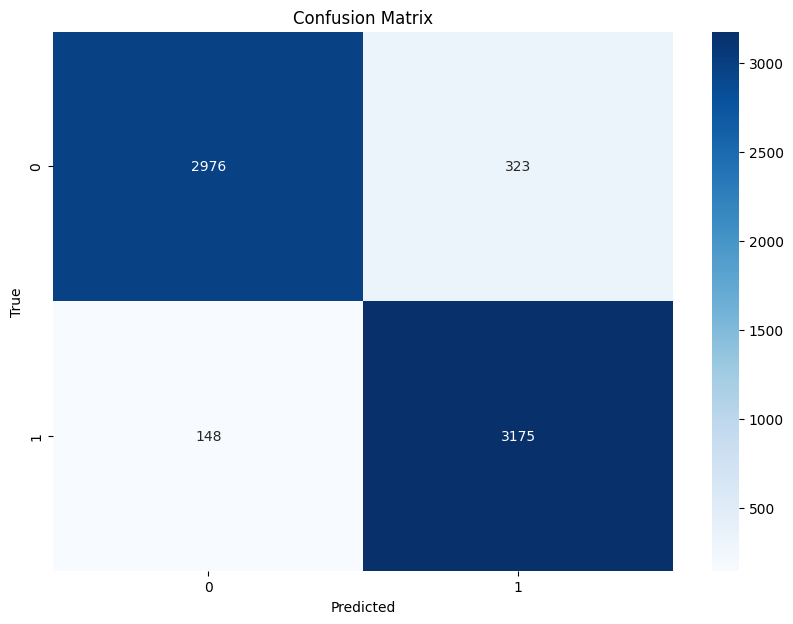

In [ ]:
test_model(model, test_dataloader, BEST_WEIGHT_PATH, device)

# TensorFlow Conversion and Save

In [ ]:
# Assicurati che le cartelle esistano
os.makedirs(MODEL_PATH, exist_ok=True)

# Carica il modello PyTorch
model_name = 'distilbert-base-uncased'
pytorch_model = DistilBertForSequenceClassification.from_pretrained(model_name, num_labels=2)

# Verifica il numero di classi nel modello PyTorch
num_labels_pytorch = pytorch_model.num_labels

# Carica i pesi del modello PyTorch
pytorch_model.load_state_dict(torch.load(os.path.join(BEST_WEIGHT_PATH, 'weights.pth')))
weights = pytorch_model.classifier.weight.detach().numpy().T
biases = pytorch_model.classifier.bias.detach().numpy()

# Carica il modello TensorFlow
tf_model = TFDistilBertForSequenceClassification.from_pretrained(model_name, num_labels=num_labels_pytorch)

# Imposta i pesi per il layer classifier
tf_model.classifier.set_weights([weights, biases])

# Salva i pesi del modello TensorFlow in un unico file H5
weights_h5_path = os.path.join(MODEL_PATH, 'weights.h5')
tf_model.save_weights(weights_h5_path)

# Salva il modello TensorFlow in formato PB
model_pb_path = os.path.join(MODEL_PATH, 'saved_model.pb')
tf.saved_model.save(tf_model, model_pb_path)

print("Modello salvato in formato PB e pesi salvati in formato H5.")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g

Modello salvato in formato PB e pesi salvati in formato H5.
